# Notebook Execution Guide

1. Activate the repo context (first code cell) to ensure `.venv` and `src/` imports.
2. Stage 1 (baseline/optimization) – run once per configuration.
3. Stage 2 (analysis and plots) – rerun freely after Stage 1 completes.
4. Stage 3 (exports or optional studies) – execute if you need derived artifacts.

Stick to Stage 1 before rerunning analysis when parameters change.


This notebook sweeps the number of CRAB basis functions for the transverse (K_omega) and detuning (K_delta) channels when optimizing the same GRAPE cost function with the ADAM optimizer.

We reuse the pulse shapes and penalties from earlier step-size experiments and collect per-run metrics (cost, runtime, gradient norms) to quantify how basis capacity changes convergence.

**Sweep definition**

- K_omega ? {4, 8, 16, 24}
- K_delta ? {0, 4, 8}
- Deterministic setup (no random seeds), 5 minute runtime budget, ADAM hyperparameters fixed across runs.

In [1]:
# === Imports (patched for WSL) ===
from pathlib import Path
import sys
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Ensure repo root on sys.path ---
if "__file__" in globals():
    notebook_dir = Path(globals()["__file__"]).resolve().parent
else:
    notebook_dir = Path.cwd()

repo_root_guess = (
    notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
)
if str(repo_root_guess) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root_guess))

# --- Safe activate_repository replacement ---
try:
    from src.notebook_setup import activate_repository
    repo_root = activate_repository(context=globals())
except Exception as e:
    print(f"[activate_repository skipped due to error: {e}]")
    repo_root = repo_root_guess

# --- Continue as before ---
from src import override_from_dict, run_experiment
from src.notebook_runners import (
    build_base_config,
    method_options,
    prepare_baseline,
)
print("Imports complete — repo_root:", repo_root)


Imports complete — repo_root: /home/yehon/projects/grape-crab-qoc


In [ ]:
# Experiment configuration inputs
# Baseline grid/shape parameters
time_grid_params = {
    'duration_us': 0.1,
    'num_points': 2001,
    'start_us': 0.0,
}
omega_shape = {'kind': 'polynomial', 'area_pi': 4.0}
delta_shape = {'kind': 'polynomial_chirp', 'area_pi': 0.0, 'amplitude_scale': 150.0}

# Basis sweep grid
K_OMEGA_VALUES = (1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24)
K_DELTA_VALUES = (0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24)

# Optional state / pulse seeds (set to None to use defaults)
rho0 = [[1.0, 0.0], [0.0, 0.0]]
target = [[0.0, 0.0], [0.0, 1.0]]
initial_omega = None
initial_delta = None

# Optimizer runtime and convergence controls
max_time_min = 5.0  # per optimization budget in minutes
max_iters = 200
grad_tol = 1e-10
rtol = 1e-10

BASE_OPTIMIZER_COMMON = {
    'max_iters': int(max_iters),
    'grad_tol': float(grad_tol),
    'rtol': float(rtol),
    'max_time_s': float(max_time_min) * 60.0,
}

# ADAM hyperparameters (fixed across sweep)
adam_learning_rate = 0.05
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
lr_decay = 1.0

ADAM_OVERRIDES = {
    'learning_rate': float(adam_learning_rate),
    'beta1': float(beta1),
    'beta2': float(beta2),
    'epsilon': float(epsilon),
    'lr_decay': float(lr_decay),
}

# Stage 1 penalty weights
power_weight = 1.0e-5
neg_weight = 1.0e-8
neg_kappa = 10.0

PENALTIES = {
    'power_weight': float(power_weight),
    'neg_weight': float(neg_weight),
    'neg_kappa': float(neg_kappa),
}

# Artifact/output naming
artifact_root = Path('./artifacts')
run_name_base = 'basis-capacity'
objective = 'terminal'


# Execution order
# Stage 1: baseline + optimization (run once)
# Stage 2: analysis/plots (safe to rerun)
# Stage 3: exports (optional)

In [3]:
# Helper utilities
def extract_history_series(history: Dict[str, Any]) -> Dict[str, np.ndarray | None]:
    def _pull(key: str, dtype=float):
        series = history.get(key)
        if series is None:
            return None
        arr = np.asarray(series, dtype=dtype)
        return arr if arr.size else None

    return {
        'iter': _pull('iter', dtype=np.int64),
        'cost_total': _pull('total', dtype=float),
        'cost_terminal': _pull('terminal', dtype=float),
        'cost_power': _pull('power_penalty', dtype=float),
        'cost_neg': _pull('neg_penalty', dtype=float),
        'grad_norm': _pull('grad_norm', dtype=float),
        'step_norm': _pull('step_norm', dtype=float),
        'lr': _pull('lr', dtype=float),
        'calls_per_iter': _pull('calls_per_iter', dtype=np.int64),
    }


def summarize_adam_result(result) -> tuple[Dict[str, Any], Dict[str, np.ndarray | None]]:
    history_map = extract_history_series(result.history)
    total_series = history_map.get('cost_total')
    iterations = int(total_series.size) if total_series is not None else 0

    grad_series = history_map.get('grad_norm')
    grad_final = float(grad_series[-1]) if grad_series is not None and grad_series.size else float('nan')
    step_series = history_map.get('step_norm')
    step_final = float(step_series[-1]) if step_series is not None and step_series.size else float('nan')
    calls_series = history_map.get('calls_per_iter')
    oracle_calls = int(np.asarray(calls_series, dtype=np.int64).sum()) if calls_series is not None else 0

    metrics = result.final_metrics
    pulses = result.pulses
    omega_final = np.asarray(pulses.get('omega'), dtype=np.float64)
    t_us = np.asarray(pulses.get('t_us'), dtype=np.float64)

    summary = {
        'total_final': float(metrics.get('total', np.nan)),
        'terminal_final': float(metrics.get('terminal', np.nan)),
        'power_final': float(metrics.get('power_penalty', 0.0)),
        'neg_final': float(metrics.get('neg_penalty', 0.0)),
        'runtime_s': float(metrics.get('runtime_s', np.nan)),
        'iterations': iterations,
        'grad_norm_final': grad_final,
        'step_norm_final': step_final,
        'oracle_calls': oracle_calls,
        'max_abs_omega': float(np.max(np.abs(omega_final))) if omega_final.size else float('nan'),
        'area_omega_over_pi': float(np.trapezoid(np.abs(omega_final), t_us) / np.pi) if omega_final.size and t_us.size else float('nan'),
        'negativity_fraction': float(np.mean(omega_final < 0.0)) if omega_final.size else float('nan'),
        'run_name': result.run_name,
        'artifacts_dir': str(result.artifacts_dir),
    }

    status_info = result.optimizer_state or {}
    status = str(status_info.get('status', 'unknown'))
    summary['status'] = status
    summary['status_detail'] = status
    return summary, history_map


In [4]:
# Run ADAM sweep over (K_omega, K_delta) pairs
sweep_records: list[Dict[str, Any]] = []
history_by_basis: Dict[Tuple[int, int], Dict[str, np.ndarray | None]] = {}
pulses_by_basis: Dict[Tuple[int, int], Dict[str, np.ndarray]] = {}

for K_omega in K_OMEGA_VALUES:
    for K_delta in K_DELTA_VALUES:
        run_label = f'{run_name_base}-Ko{K_omega:02d}-Kd{K_delta:02d}'
        print(f"[adam][Ko={K_omega:02d} Kd={K_delta:02d}] starting optimization")

        ctx = prepare_baseline(
            time_grid=time_grid_params,
            omega_shape=omega_shape,
            delta_shape=delta_shape,  # preserve baseline detuning even when K_delta=0
            K_omega=int(K_omega),
            K_delta=int(K_delta),
            rho0=rho0,
            target=target,
            initial_omega=initial_omega,
            initial_delta=initial_delta,
        )

        base_opts = dict(BASE_OPTIMIZER_COMMON)
        base_opts['optimize_delta'] = bool(K_delta > 0)

        base_config, base_options = build_base_config(
            ctx.config,
            run_name=run_label,
            artifact_root=artifact_root,
            penalties=PENALTIES,
            objective=objective,
            base_optimizer_options=base_opts,
        )

        adam_options = method_options('adam', base_options, ADAM_OVERRIDES)
        config = override_from_dict(base_config, {'optimizer_options': adam_options})

        result = run_experiment(
            config,
            method='adam',
            run_name=run_label,
            exist_ok=True,
        )

        summary, history_map = summarize_adam_result(result)
        summary['K_omega'] = int(K_omega)
        summary['K_delta'] = int(K_delta)
        sweep_records.append(summary)
        history_by_basis[(int(K_omega), int(K_delta))] = history_map
        pulses_by_basis[(int(K_omega), int(K_delta))] = {
            'omega': np.asarray(result.pulses.get('omega'), dtype=np.float64),
            'delta': None if result.pulses.get('delta') is None else np.asarray(result.pulses.get('delta'), dtype=np.float64),
            't_us': np.asarray(result.pulses.get('t_us'), dtype=np.float64),
        }

        print(f"[adam][Ko={K_omega:02d} Kd={K_delta:02d}] finished (status={summary['status']})")


[adam][Ko=01 Kd=00] starting optimization
[adam][Ko=01 Kd=00] finished (status=max_iters)
[adam][Ko=01 Kd=02] starting optimization
[adam][Ko=01 Kd=02] finished (status=max_iters)
[adam][Ko=01 Kd=04] starting optimization
[adam][Ko=01 Kd=04] finished (status=max_iters)
[adam][Ko=01 Kd=06] starting optimization
[adam][Ko=01 Kd=06] finished (status=max_iters)
[adam][Ko=01 Kd=08] starting optimization
[adam][Ko=01 Kd=08] finished (status=max_iters)
[adam][Ko=01 Kd=10] starting optimization
[adam][Ko=01 Kd=10] finished (status=max_iters)
[adam][Ko=01 Kd=12] starting optimization
[adam][Ko=01 Kd=12] finished (status=max_iters)
[adam][Ko=01 Kd=14] starting optimization
[adam][Ko=01 Kd=14] finished (status=max_iters)
[adam][Ko=01 Kd=16] starting optimization
[adam][Ko=01 Kd=16] finished (status=max_iters)
[adam][Ko=01 Kd=18] starting optimization
[adam][Ko=01 Kd=18] finished (status=max_iters)
[adam][Ko=01 Kd=20] starting optimization
[adam][Ko=01 Kd=20] finished (status=max_iters)
[adam][Ko=

In [5]:
# Compile summary table
summary_df = pd.DataFrame(sweep_records)
if not summary_df.empty:
    ordered_columns = [
        'K_omega',
        'K_delta',
        'status',
        'total_final',
        'terminal_final',
        'runtime_s',
        'iterations',
        'grad_norm_final',
        'step_norm_final',
        'oracle_calls',
        'max_abs_omega',
        'area_omega_over_pi',
        'negativity_fraction',
        'run_name',
        'artifacts_dir',
    ]
    available_columns = [col for col in ordered_columns if col in summary_df.columns]
    summary_df = summary_df[available_columns].sort_values(['K_delta', 'K_omega']).reset_index(drop=True)
summary_df


K_omega  K_delta     status  total_final  terminal_final  runtime_s  \
0          1        0  max_iters     0.036160    3.858912e-04  12.780290   
1          2        0  max_iters     0.036290    4.870699e-04   9.160960   
2          4        0  max_iters     0.034466    1.717233e-05   9.459448   
3          6        0  max_iters     0.032714    5.256792e-06   8.216251   
4          8        0  max_iters     0.031699    4.744554e-06   8.560312   
..       ...      ...        ...          ...             ...        ...   
164       16       24  max_iters     0.035946    1.742044e-06   8.249206   
165       18       24  max_iters     0.034820    3.569349e-07   8.422868   
166       20       24  max_iters     0.036083    3.819727e-07   8.473021   
167       22       24  max_iters     0.034713    5.242933e-07   8.113928   
168       24       24  max_iters     0.035676    9.356368e-07   8.607810   

     iterations  grad_norm_final  step_norm_final  oracle_calls  \
0           200         0.002295         0.006777           200   
1           200         0.002345         0.024129           200   
2           200         0.000179         0.001924           200   
3           200         0.000467         0.010940           200   
4           200         0.000616         0.013073           200   
..          ...              ...              ...           ...   
164         200         0.000926         0.212424           200   
165         200         0.000849         0.201403           200   
166         200         0.000773         0.234031           200   
167         200         0.000783         0.224573           200   
168         200         0.000844         0.227642           200   

     max_abs_omega  area_omega_over_pi  negativity_fraction  \
0       215.287862            4.649029             0.000000   
1       217.930204            4.648412             0.000000   
2       229.323101            4.602161             0.000000   
3       213.296834            4.469671             0.000000   
4       213.108956            4.418739             0.000000   
..             ...                 ...                  ...   
164     224.758136            4.182601             0.000000   
165     204.473570            4.188329             0.002999   
166     248.487153            4.185635             0.000000   
167     229.589491            4.195847             0.011494   
168     253.219836            4.190720             0.015492   

                     run_name                       artifacts_dir  
0    basis-capacity-Ko01-Kd00  artifacts/basis-capacity-Ko01-Kd00  
1    basis-capacity-Ko02-Kd00  artifacts/basis-capacity-Ko02-Kd00  
2    basis-capacity-Ko04-Kd00  artifacts/basis-capacity-Ko04-Kd00  
3    basis-capacity-Ko06-Kd00  artifacts/basis-capacity-Ko06-Kd00  
4    basis-capacity-Ko08-Kd00  artifacts/basis-capacity-Ko08-Kd00  
..                        ...                                 ...  
164  basis-capacity-Ko16-Kd24  artifacts/basis-capacity-Ko16-Kd24  
165  basis-capacity-Ko18-Kd24  artifacts/basis-capacity-Ko18-Kd24  
166  basis-capacity-Ko20-Kd24  artifacts/basis-capacity-Ko20-Kd24  
167  basis-capacity-Ko22-Kd24  artifacts/basis-capacity-Ko22-Kd24  
168  basis-capacity-Ko24-Kd24  artifacts/basis-capacity-Ko24-Kd24  

[169 rows x 15 columns]

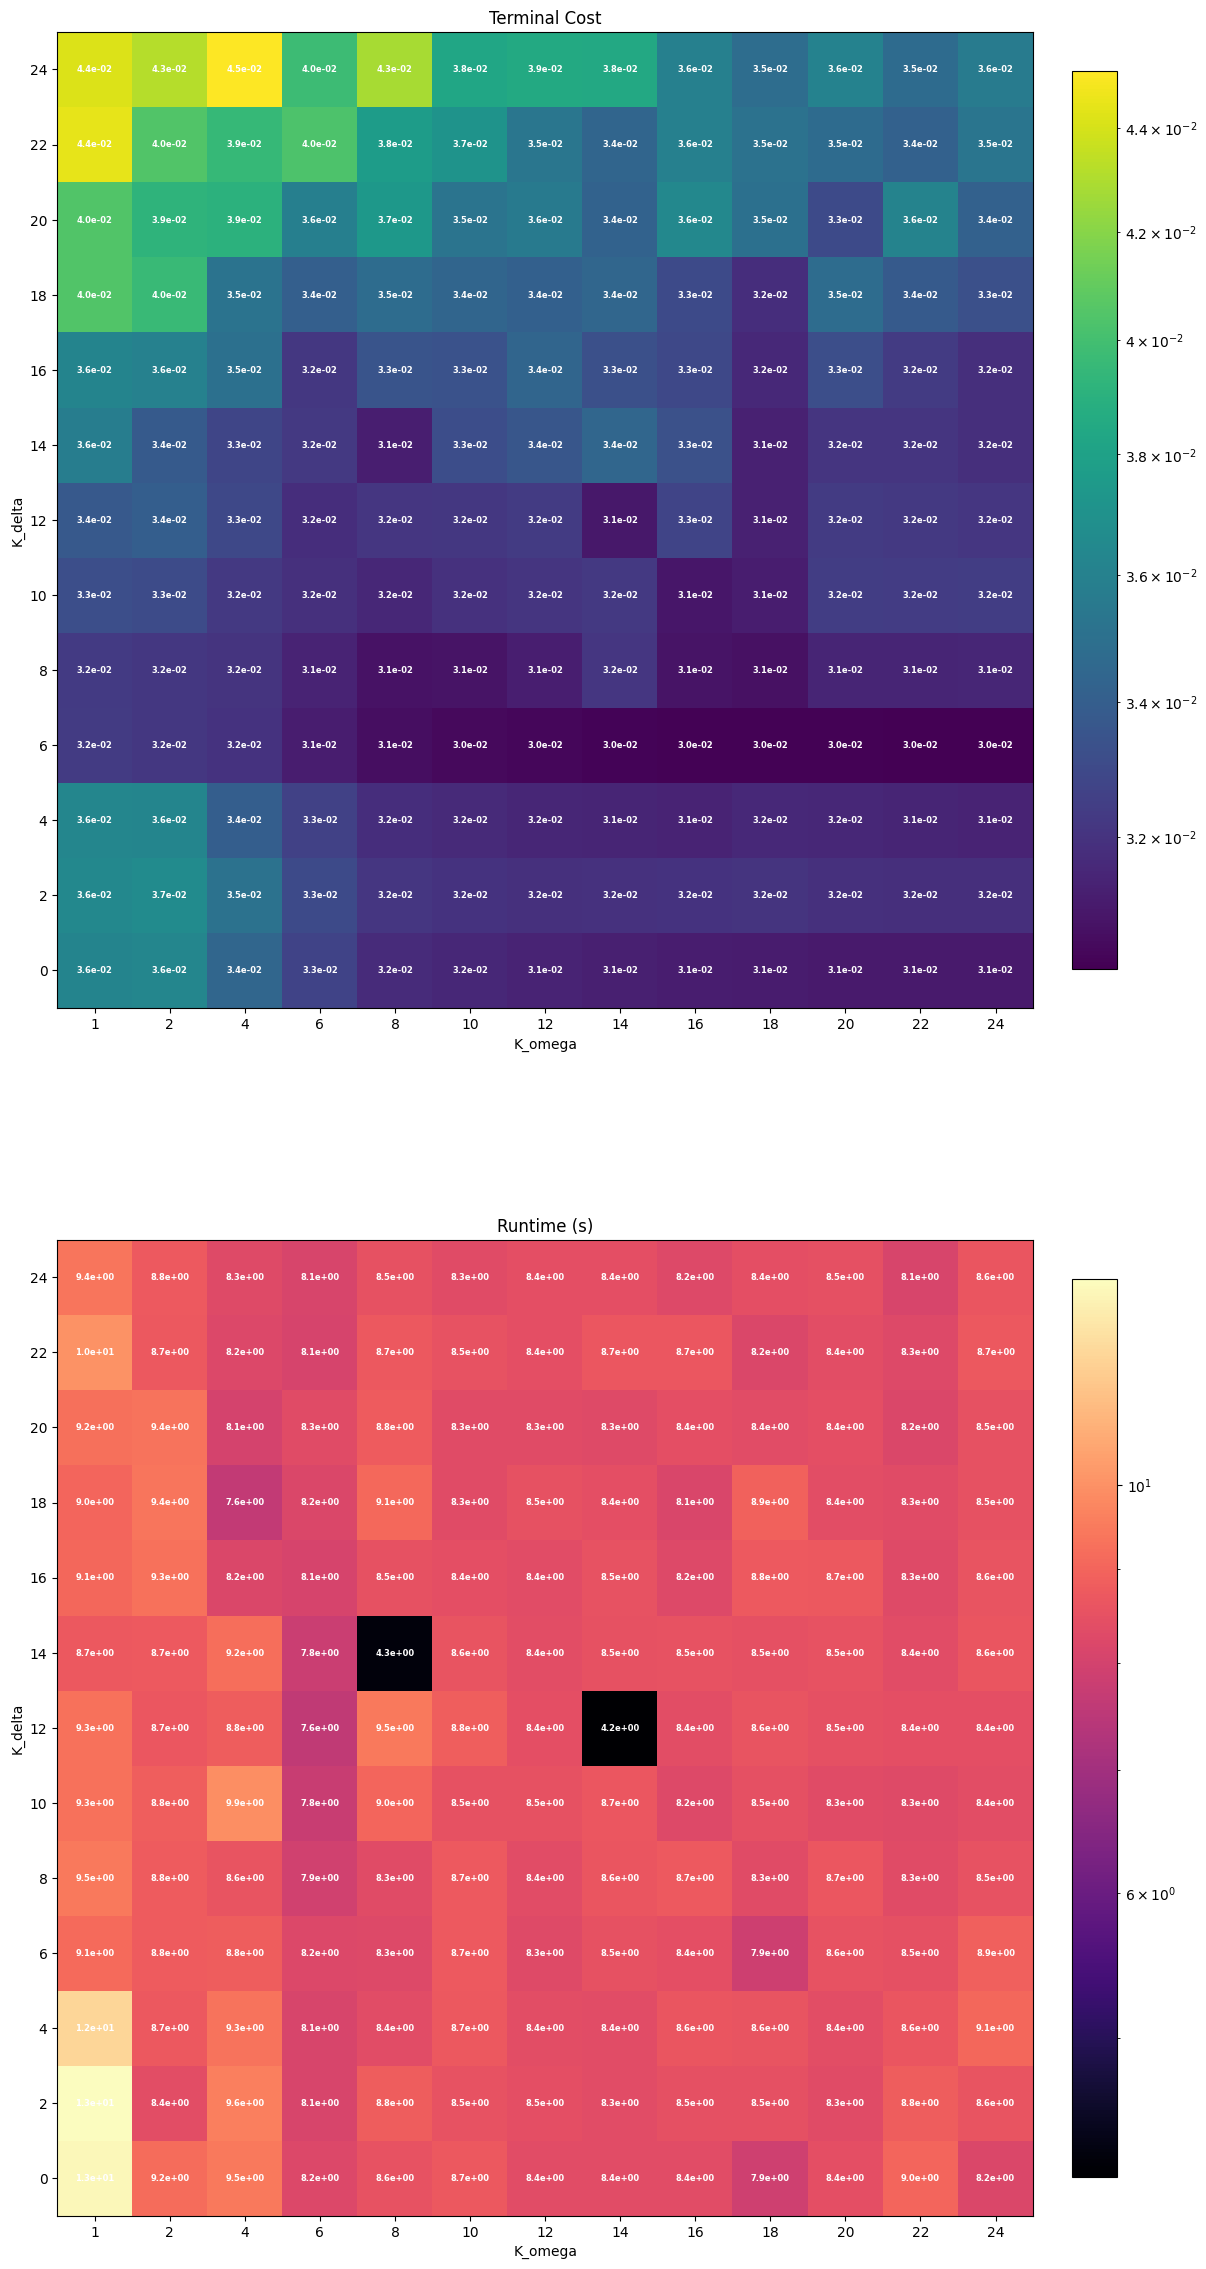

In [6]:
from matplotlib.colors import LogNorm
# Heatmaps for terminal infidelity and runtime
if not summary_df.empty:
    pivot_terminal = summary_df.pivot(index='K_delta', columns='K_omega', values='total_final')
    pivot_runtime = summary_df.pivot(index='K_delta', columns='K_omega', values='runtime_s')

    fig, axes = plt.subplots(2, 1, figsize=(12, 24), constrained_layout=True)
    ims = [
        axes[0].imshow(pivot_terminal.values,norm=LogNorm(vmin=pivot_terminal.values.min(), vmax=pivot_terminal.values.max()), origin='lower', cmap='viridis'),
        axes[1].imshow(pivot_runtime.values, norm=LogNorm(vmin=pivot_runtime.values.min(), vmax=pivot_runtime.values.max()), origin='lower', cmap='magma'),
    ]
    axes[0].set_title('Terminal Cost')
    axes[1].set_title('Runtime (s)')

    for ax, pivot in zip(axes, [pivot_terminal, pivot_runtime]):
        ax.set_xticks(range(pivot.shape[1]))
        ax.set_xticklabels(pivot.columns)
        ax.set_yticks(range(pivot.shape[0]))
        ax.set_yticklabels(pivot.index)
        ax.set_xlabel('K_omega')
        ax.set_ylabel('K_delta')
        for (i, j), value in np.ndenumerate(pivot.values):
            ax.text(j, i, f"{value:.1e}", ha='center', va='center', color='white', fontsize=6, fontweight='bold')
    for ax, im in zip(axes, ims):
        fig.colorbar(im, ax=ax , fraction=0.046, pad=0.04)
    plt.show()


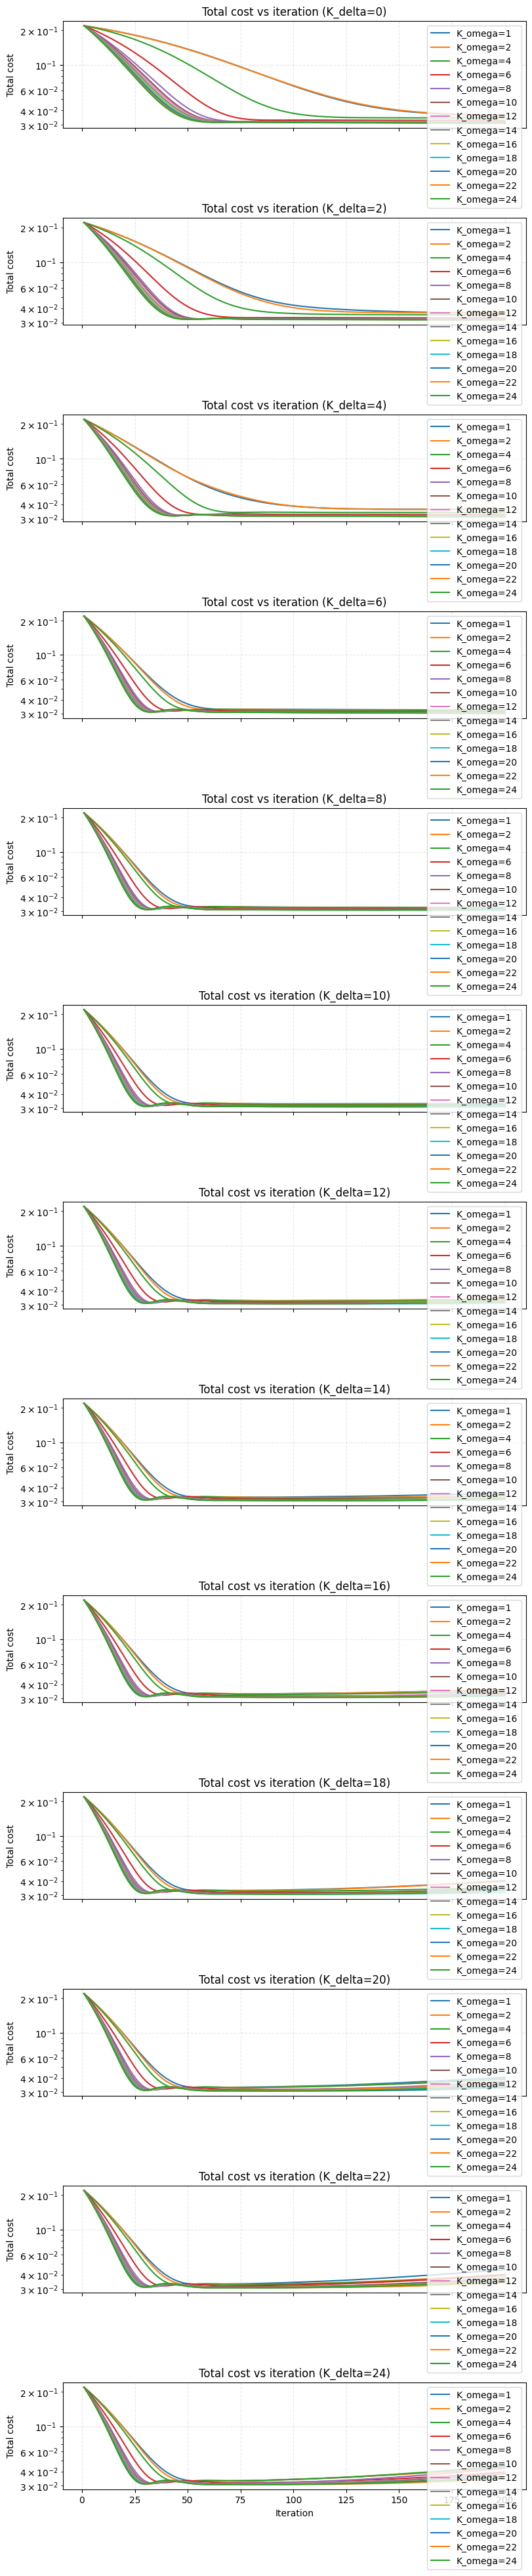

In [7]:
# Cost trajectories grouped by K_delta
if history_by_basis:
    fig, axes = plt.subplots(len(K_DELTA_VALUES), 1, figsize=(8, 3 * len(K_DELTA_VALUES)), sharex=True, constrained_layout=True)
    if len(K_DELTA_VALUES) == 1:
        axes = [axes]
    for idx, K_delta in enumerate(K_DELTA_VALUES):
        ax = axes[idx]
        for K_omega in K_OMEGA_VALUES:
            history = history_by_basis.get((K_omega, K_delta))
            if not history:
                continue
            total_series = history.get('cost_total')
            iter_series = history.get('iter')
            if total_series is None:
                continue
            x_axis = iter_series if iter_series is not None and iter_series.size == total_series.size else np.arange(total_series.size)
            ax.plot(x_axis, total_series, label=f'K_omega={K_omega}')
        ax.set_title(f'Total cost vs iteration (K_delta={K_delta})')
        ax.set_ylabel('Total cost')
        ax.set_yscale('log')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel('Iteration')
    plt.show()


## Pulse Comparisons

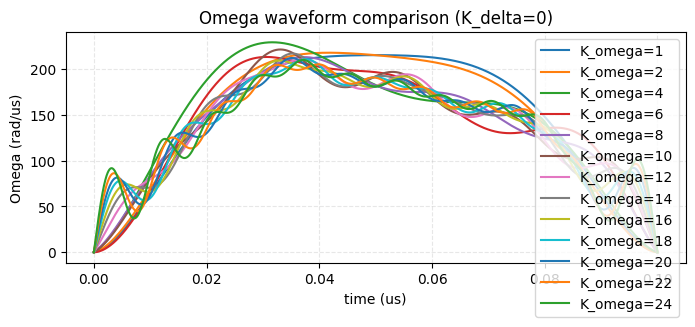

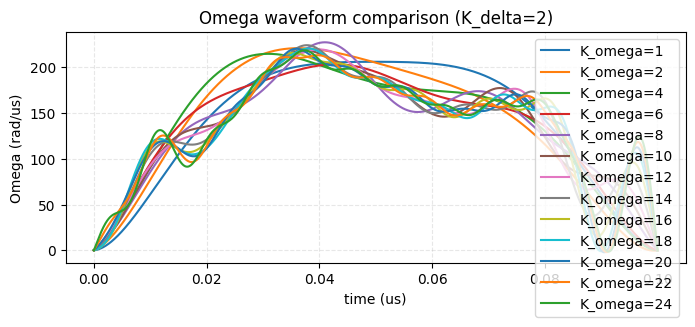

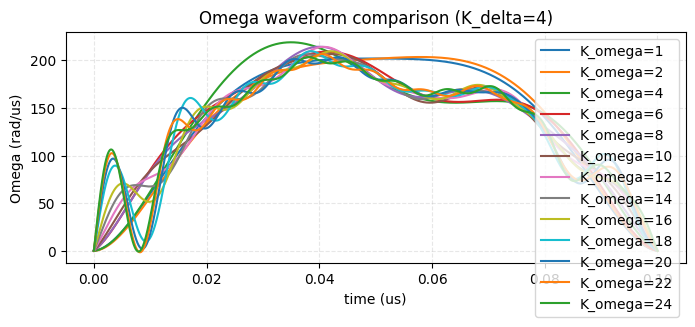

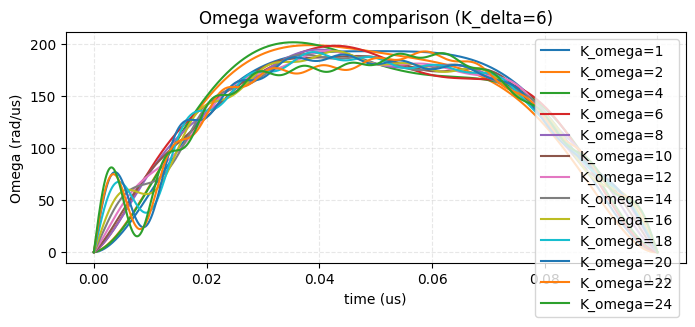

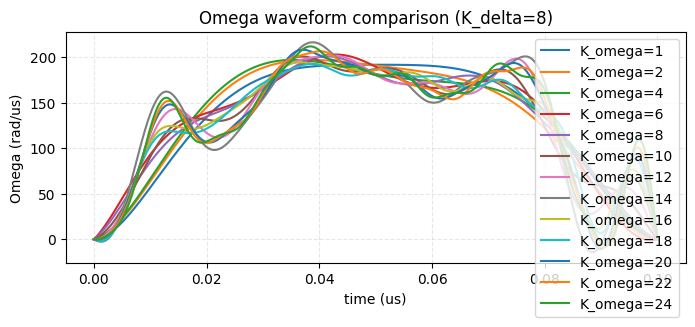

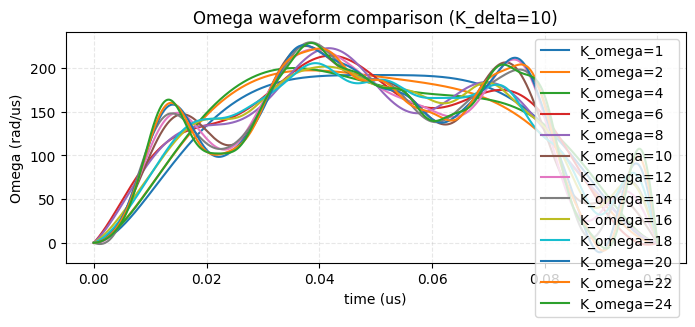

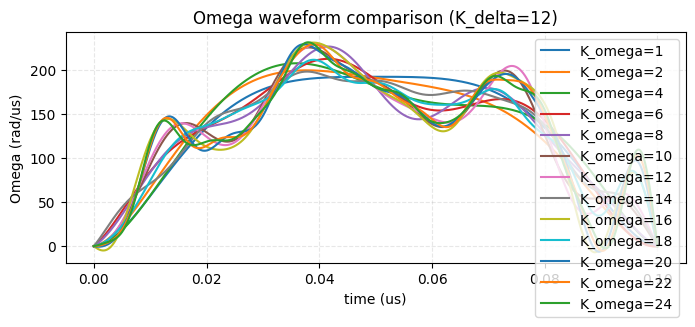

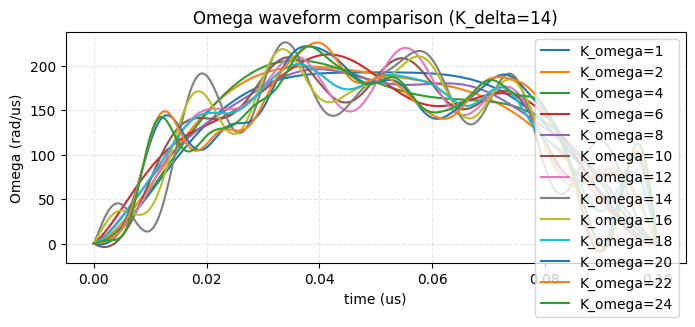

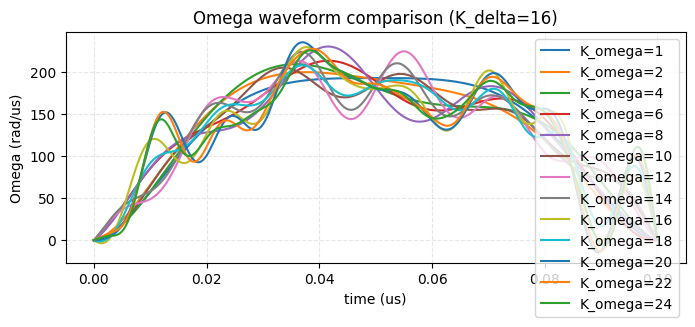

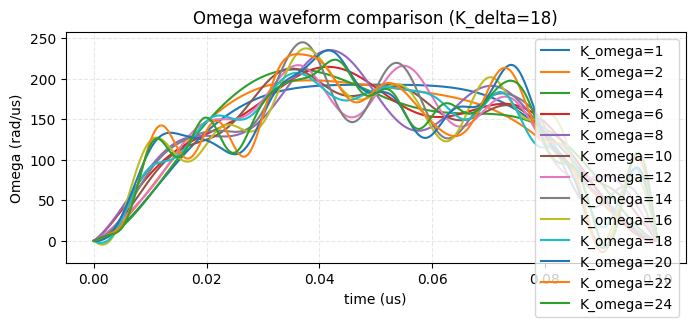

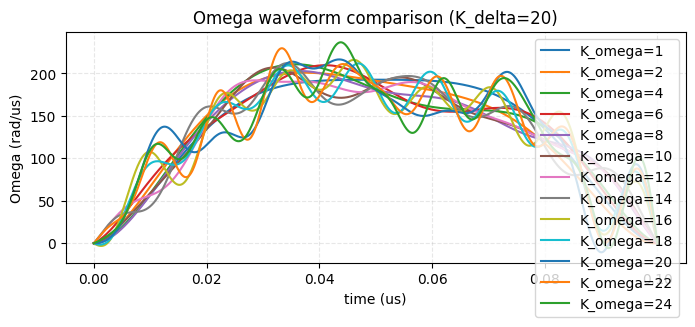

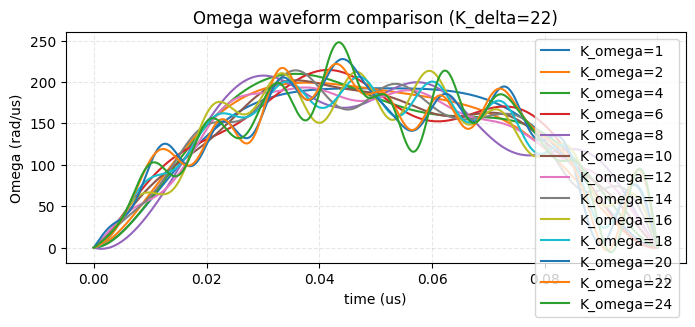

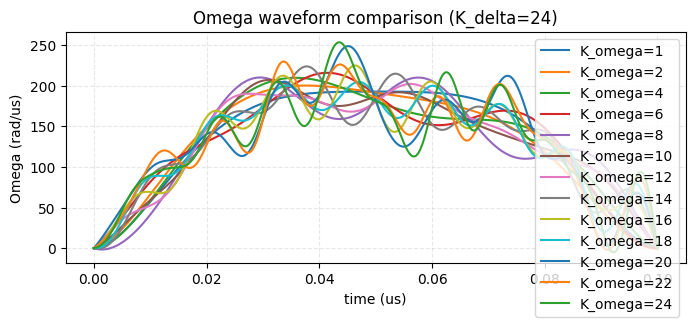

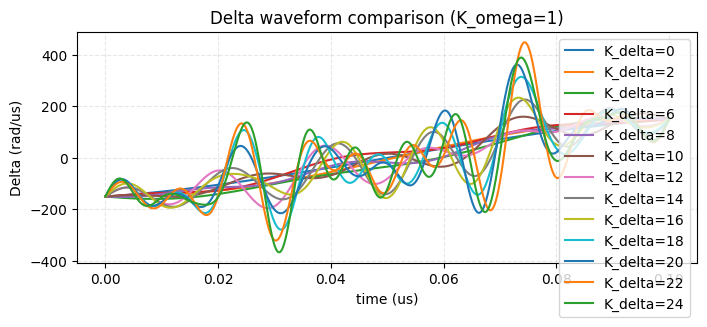

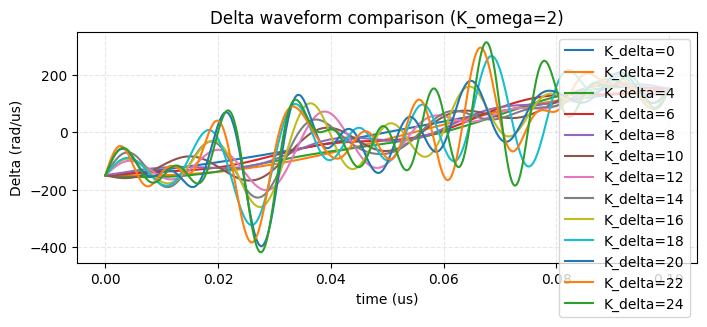

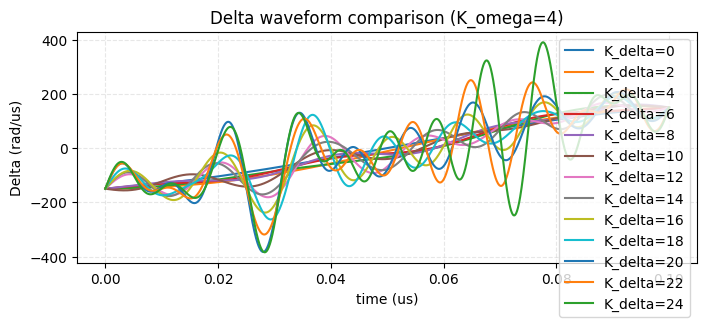

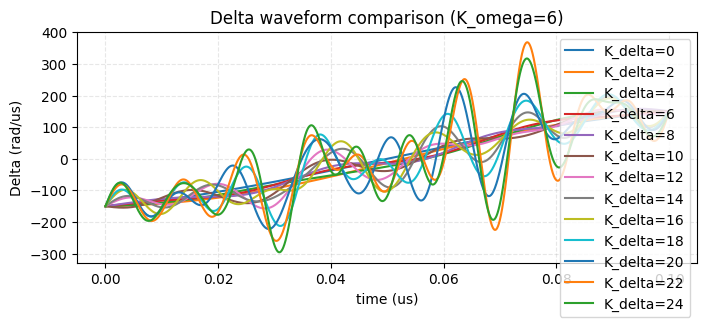

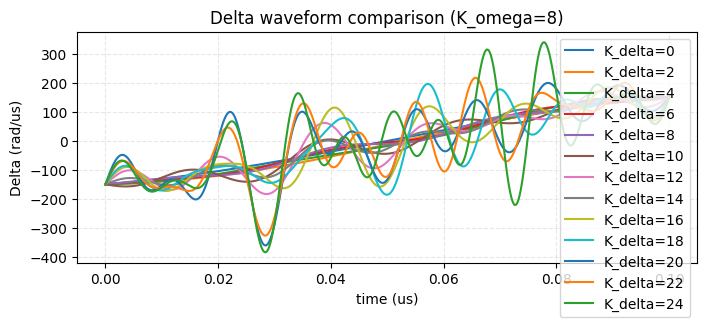

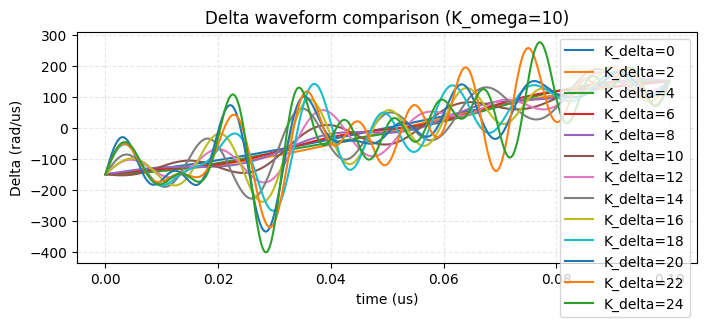

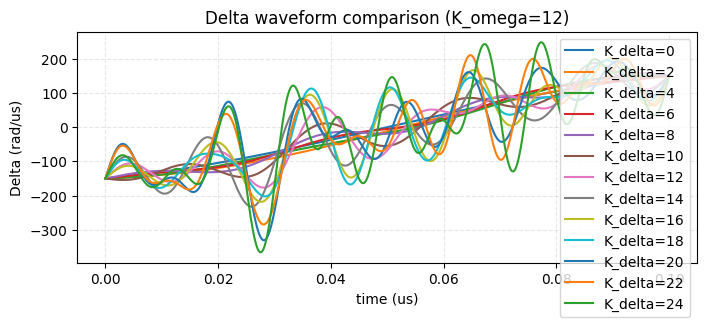

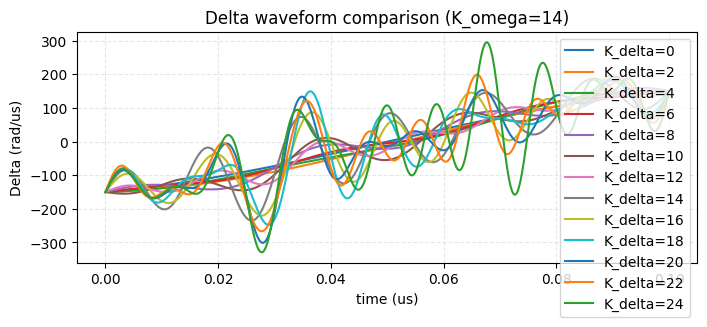

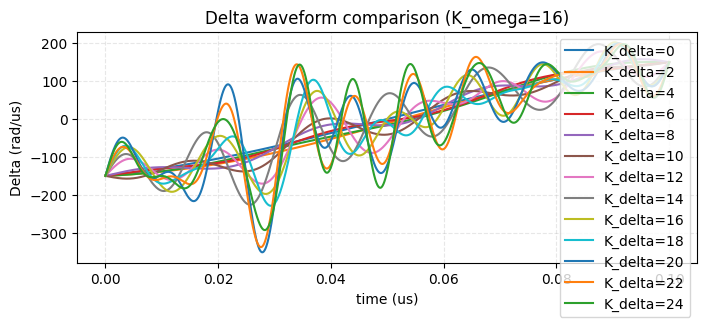

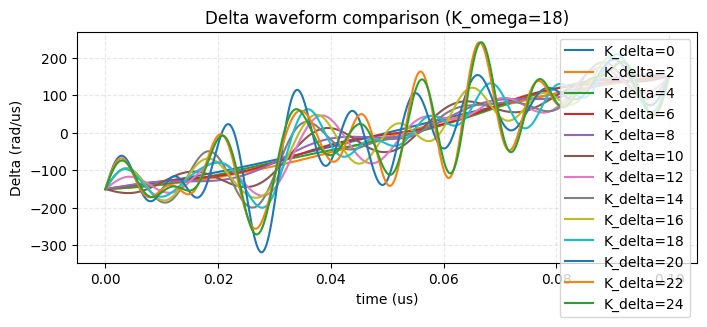

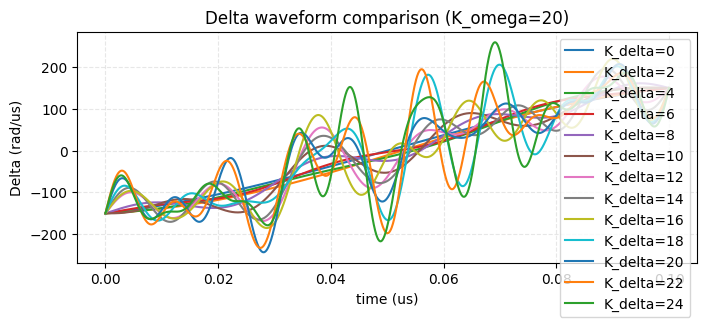

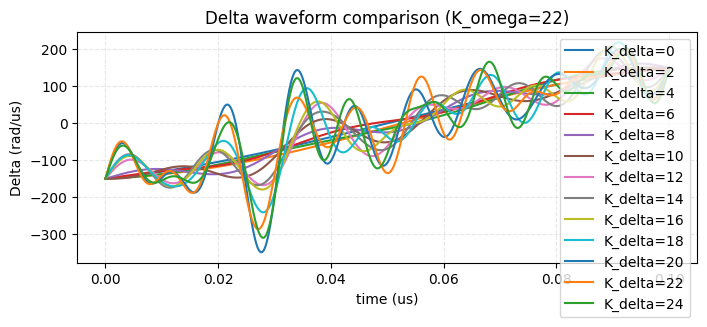

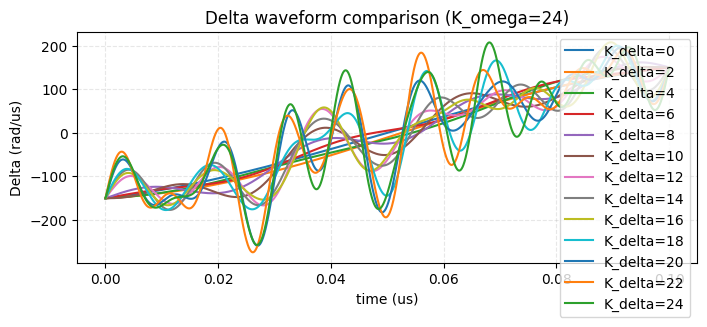

In [8]:
# Compare optimized pulses across basis sizes
if not pulses_by_basis:
    print('Run the sweep above before plotting pulses.')
else:
    for K_delta in K_DELTA_VALUES:
        fig, ax = plt.subplots(figsize=(8, 3))
        for K_omega in K_OMEGA_VALUES:
            pulses = pulses_by_basis.get((K_omega, K_delta))
            if not pulses:
                continue
            t_us = pulses.get('t_us')
            omega = pulses.get('omega')
            if t_us is None or omega is None or getattr(omega, 'size', 0) == 0:
                continue
            ax.plot(t_us, omega, label=f'K_omega={K_omega}')
        ax.set_title(f'Omega waveform comparison (K_delta={K_delta})')
        ax.set_xlabel('time (us)')
        ax.set_ylabel('Omega (rad/us)')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
        plt.show()

    any_delta = any((p.get('delta') is not None and getattr(p.get('delta'), 'size', 0) > 0) for p in pulses_by_basis.values())
    if any_delta:
        for K_omega in K_OMEGA_VALUES:
            fig, ax = plt.subplots(figsize=(8, 3))
            for K_delta in K_DELTA_VALUES:
                pulses = pulses_by_basis.get((K_omega, K_delta))
                if not pulses:
                    continue
                t_us = pulses.get('t_us')
                delta = pulses.get('delta')
                if t_us is None or delta is None or getattr(delta, 'size', 0) == 0:
                    continue
                ax.plot(t_us, delta, label=f'K_delta={K_delta}')
            ax.set_title(f'Delta waveform comparison (K_omega={K_omega})')
            ax.set_xlabel('time (us)')
            ax.set_ylabel('Delta (rad/us)')
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()
            plt.show()
    else:
        print('No detuning waveforms were optimized (all K_delta = 0).')

## Aggregated Metrics

In [9]:
# Summaries grouped by basis size
if summary_df.empty:
    print('Run the sweep above before computing aggregates.')
else:
    metrics_cols = ['total_final', 'terminal_final', 'runtime_s']
    stats_by_delta = summary_df.groupby('K_delta')[metrics_cols].agg(['mean', 'min', 'max'])
    stats_by_omega = summary_df.groupby('K_omega')[metrics_cols].agg(['mean', 'min', 'max'])
    print('Aggregated metrics by K_delta:')
    print(stats_by_delta.round(6))
    print('Aggregated metrics by K_omega:')
    print(stats_by_omega.round(6))

Aggregated metrics by K_delta:
        total_final                     terminal_final                      \
               mean       min       max           mean       min       max   
K_delta                                                                      
0          0.032378  0.031030  0.036290       0.000072  0.000004  0.000487   
2          0.032980  0.031824  0.036623       0.000035  0.000002  0.000271   
4          0.032526  0.031375  0.036277       0.000019  0.000004  0.000106   
6          0.030811  0.030158  0.032372       0.000003  0.000001  0.000010   
8          0.031444  0.030721  0.032297       0.000002  0.000001  0.000006   
10         0.032118  0.030884  0.033225       0.000003  0.000000  0.000027   
12         0.032381  0.030948  0.034015       0.000004  0.000000  0.000031   
14         0.032901  0.031195  0.035790       0.000004  0.000000  0.000030   
16         0.033533  0.031600  0.036185       0.000004  0.000000  0.000027   
18         0.034904  0.031780  0.

## Export Summaries

In [10]:
# Persist tabular data for reuse
if summary_df.empty:
    print('Run the sweep above before exporting summary tables.')
else:
    export_dir = (artifact_root / 'basis_capacity_sweep').resolve()
    export_dir.mkdir(parents=True, exist_ok=True)
    csv_path = export_dir / 'summary.csv'
    json_path = export_dir / 'summary.json'
    summary_df.to_csv(csv_path, index=False)
    summary_df.to_json(json_path, orient='records', indent=2)
    print(f'Wrote {csv_path}')
    print(f'Wrote {json_path}')

Wrote /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/summary.csv
Wrote /home/yehon/projects/grape-crab-qoc/artifacts/basis_capacity_sweep/summary.json


## Further Exploration

- Extend robustness analysis by activating ensemble objectives or noise sweeps.
- Experiment with adaptive basis schedules (for example, increase K_omega during optimization).
- Integrate these results into reporting or automation once the sweep stabilizes.